# Model Tuning with Optuna

*"With great models, comes the great problem of optimizing hyperparameters."* &mdash; GM Abishek Thakur {cite}`AAAMLP`

<br>

Hyperparameters are **non-learnable parameters** of a model that determine its architecture. The correct choice of hyperparameters could mean the difference between convergence to or divergence from a solution. In this notebook, we look at functionalities the open-source library [Optuna](https://optuna.org/) provides as a framework for solving this task. From the [docs](https://optuna.readthedocs.io/en/stable/index.html#):

> *Optuna* is an automatic hyperparameter optimization software framework, particularly designed for machine learning. It features an imperative, *define-by-run* style user API. Thanks to our *define-by-run* API, the code written with Optuna enjoys high modularity, and the user of Optuna can dynamically construct the search spaces for the hyperparameters.

- [Optuna FAQ](https://optuna.readthedocs.io/en/stable/faq.html)
- [Optuna docs](https://optuna.readthedocs.io/en/stable/index.html#)
- [Optuna paper](https://arxiv.org/abs/1907.10902)

In [81]:
import optuna
import joblib
import pandas as pd
from functools import partial

from sklearn import ensemble, svm
from sklearn import datasets
from sklearn import model_selection

import plotly.io as pio
pio.renderers.default = "notebook_connected"

## Fundamentals with scikit-learn

Optuna only needs an objective function to evaluate the performance of hyperparameters and decide where to sample in upcoming trials &mdash; i.e. it is a black box optimizer. 

An optimization problem in the Optuna API is setup using two basic objects: a `study` and a `trial`. A study is conceptually an optimization based on an objective function, while a trial is a single execution of an objective function. The combination of hyperparameters for each trial is sampled according to some sampling algorithm defined by the study. 




In the following code example, the search space is constructed within imperative Python code, e.g. inside conditionals or loops. Recall that for `GridSearchCV` and `RandomSearchCV` in scikit-learn, we had to define the entire search space before running the search algorithm.

```{tip}
Always perform model evaluation on a dataset within a cross-validation framework!
```


In [82]:
# [1] Define an objective function to be maximized.
def objective(trial, X, y):
    
    # [2] Suggest values for the hyperparameters using trial object.
    clf_name = trial.suggest_categorical('classifier', ['SVC', 'RandomForest'])
    if clf_name == 'SVC':
        svc_c = trial.suggest_loguniform('svc_c', 1e-10, 1e10)
        clf = svm.SVC(C=svc_c, gamma='auto')
    else:
        rf_max_depth = int(trial.suggest_loguniform('rf_max_depth', 2, 32))
        clf = ensemble.RandomForestClassifier(max_depth=rf_max_depth, n_estimators=10)

    score = model_selection.cross_val_score(clf, X, y, n_jobs=-1, cv=5)
    return score.mean()

# [3] Create a study object and optimize the objective function.
X, y = datasets.load_breast_cancer(return_X_y=True)
study = optuna.create_study(direction="maximize")
study.optimize(partial(objective, X=X, y=y), n_trials=5)

[I 2022-01-04 20:10:35,703] A new study created in memory with name: no-name-ecd58d42-2d3a-4682-aef1-891a41b3c754
[I 2022-01-04 20:10:37,262] Trial 0 finished with value: 0.6274181027790716 and parameters: {'classifier': 'SVC', 'svc_c': 3803.076469436384}. Best is trial 0 with value: 0.6274181027790716.
[I 2022-01-04 20:10:37,392] Trial 1 finished with value: 0.9578326346840551 and parameters: {'classifier': 'RandomForest', 'rf_max_depth': 3.6945487120070006}. Best is trial 1 with value: 0.9578326346840551.
[I 2022-01-04 20:10:37,445] Trial 2 finished with value: 0.6274181027790716 and parameters: {'classifier': 'SVC', 'svc_c': 1.3221723179302474e-08}. Best is trial 1 with value: 0.9578326346840551.
[I 2022-01-04 20:10:37,498] Trial 3 finished with value: 0.6274181027790716 and parameters: {'classifier': 'SVC', 'svc_c': 2.1525866487069006e-08}. Best is trial 1 with value: 0.9578326346840551.
[I 2022-01-04 20:10:37,598] Trial 4 finished with value: 0.9490762303990063 and parameters: {'c

The `study` object saves the result of evaluating the objective in each `trial` which is essentially some choice of hyperparameters or, more abstractly, a point in the search space. In the above study, the problem of model selection is framed as a hyperparameter optimization problem. Here we choose between SVM and Random Forest.

In [83]:
study.trials_dataframe().head()

,number,value,datetime_start,datetime_complete,duration,params_classifier,params_rf_max_depth,params_svc_c,state
0,0,0.627418,2022-01-04 20:10:35.705361,2022-01-04 20:10:37.262436,0 days 00:00:01.557075,SVC,NaN,3.803076e+03,COMPLETE
1,1,0.957833,2022-01-04 20:10:37.264278,2022-01-04 20:10:37.391820,0 days 00:00:00.127542,RandomForest,3.694549,NaN,COMPLETE
2,2,0.627418,2022-01-04 20:10:37.392966,2022-01-04 20:10:37.445550,0 days 00:00:00.052584,SVC,NaN,1.322172e-08,COMPLETE
3,3,0.627418,2022-01-04 20:10:37.446586,2022-01-04 20:10:37.498668,0 days 00:00:00.052082,SVC,NaN,2.152587e-08,COMPLETE
4,4,0.949076,2022-01-04 20:10:37.499604,2022-01-04 20:10:37.598698,0 days 00:00:00.099094,RandomForest,24.849599,NaN,COMPLETE


### Fine tuning Random Forest

Here we focus on tuning a single Random Forest model. Then, plot the accuracy for each pair of hyperparameters.

In [84]:
def objective(trial):
    
    max_depth = trial.suggest_int('max_depth', 2, 128, log=True)    
    max_features = trial.suggest_float('max_features', 0.1, 1.0)    
    n_estimators = trial.suggest_int('n_estimators', 100, 800)
    
    clf = ensemble.RandomForestClassifier(
        max_depth=max_depth,
        n_estimators=n_estimators,
        max_features=max_features,
        random_state=42)   
    
    score = model_selection.cross_val_score(clf, X, y, n_jobs=-1, cv=5)
    return score.mean()


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=60)

[I 2022-01-04 20:10:40,996] A new study created in memory with name: no-name-b9f02130-f91d-4c04-ba15-807439414dce
[I 2022-01-04 20:10:47,353] Trial 0 finished with value: 0.9596025461884802 and parameters: {'max_depth': 38, 'max_features': 0.14652009264215896, 'n_estimators': 715}. Best is trial 0 with value: 0.9596025461884802.
[I 2022-01-04 20:10:51,642] Trial 1 finished with value: 0.9613724576929048 and parameters: {'max_depth': 18, 'max_features': 0.41386486211292417, 'n_estimators': 371}. Best is trial 1 with value: 0.9613724576929048.
[I 2022-01-04 20:10:57,827] Trial 2 finished with value: 0.9613879832324173 and parameters: {'max_depth': 16, 'max_features': 0.7629314852832197, 'n_estimators': 395}. Best is trial 2 with value: 0.9613879832324173.
[I 2022-01-04 20:11:01,435] Trial 3 finished with value: 0.9613569321533924 and parameters: {'max_depth': 48, 'max_features': 0.33444659066910964, 'n_estimators': 335}. Best is trial 2 with value: 0.9613879832324173.
[I 2022-01-04 20:11

In [85]:
study.best_params

{'max_depth': 27, 'max_features': 0.3143781780078858, 'n_estimators': 151}

In [86]:
study.best_value

0.9684055270920664

### Sampling algorithms

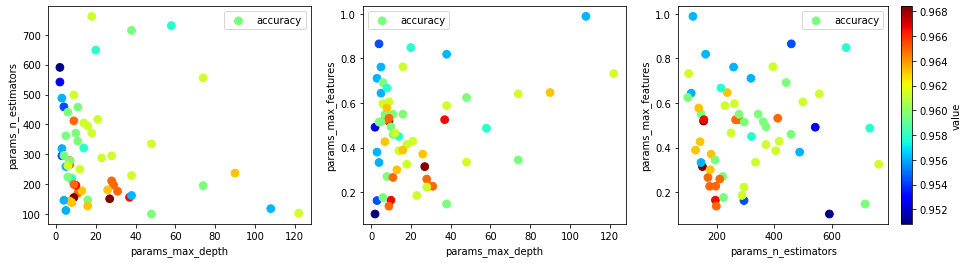

In [87]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=3)

def plot_results(study, p1, p2, j, cb):
    study.trials_dataframe().plot(
        kind='scatter', ax=axes[j], x=p1, y=p2,
        c='value', s=60, cmap=plt.get_cmap("jet"), 
        colorbar=cb, label="accuracy", figsize=(16, 4)
    )

plot_results(study, 'params_max_depth',    'params_n_estimators', j=0, cb=False)
plot_results(study, 'params_max_depth',    'params_max_features', j=1, cb=False)
plot_results(study, 'params_n_estimators', 'params_max_features', j=2, cb=True);

**Figure.** TPE in action. Optuna uses  **Tree-structured Parzen Estimater (TPE)** {cite}`bergstra` as the default sampler which is a form of Bayesian optimization. Observe that the hyperparameter space is searched more efficiently than random search with the sampler choosing points closer to previous good results. Samplers are specified when creating a study as follows: 

```python
study = create_study(direction="maximize", sampler=optuna.samplers.TPESampler())
```

From the [docs](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.samplers.TPESampler.html#optuna.samplers.TPESampler):

> On each trial, for each parameter, TPE fits one Gaussian Mixture Model (GMM) `l(x)` to the set of parameter values associated with the best objective values, and another GMM `g(x)` to the remaining parameter values. It chooses the parameter value `x` that maximizes the ratio `l(x)/g(x)`.

Thus, TPE samples every hyperparameter **independently** &mdash; no explicit hyperparameter interactions are considered when sampling future trials, although other parameters implicitly affect objective value. Optuna also implements our old friends random and grid search in the following samplers:
- `optuna.samplers.GridSampler`
- `optuna.samplers.RandomSampler`

Another sampling algorithm implemented in Optuna is **Covariance Matrix Adaptation Evolution Strategy (CMA-ES)** {cite}`hansen2016cma`. This algorithm is designed to tackle ill-conditioned, non-separable problems, i.e. cannot be solved by solving several 1-dimensional problems. CMA-ES is typically implemented along with TPE whenever the former algorithm is not applicable, e.g. for searching dynamically constructed hyperparameters (as CMA-ES requires that parameters are specified statically prior to the optimization) or for searching categorical parameters, as CMA-ES is designed to search real parameters on a continuous domain. TPE+CMA-ES sampling can be implemented as follows:

```python
sampler = optuna.samplers.CmaEsSampler(
    warn_independent_sampling=False,
    independent_sampler=optuna.samplers.TPESampler()
)
```

Results from the paper {cite}`akiba2019optuna` show that TPE+CMA-ES works better than counterparts of the same time complexity:

```{figure} ../img/fig9-optuna.png
---
width: 35em
name: fig9-optuna
---
```

```{figure} ../img/fig10-optuna.png
---
width: 35em
name: fig10-optuna
---
```

```{figure} ../img/optuna-results.png
---
width: 35em
name: optuna-results
---
```

### Results visualization

Optuna provides visualization functions in the `optuna.visualization` library [^ref4]. The following plot shows the best objective value found as the trials progress. The increasing trend in accuracy indicates that the TPE sampler is working well, i.e. the search algorithm learns from previous trials.

[^ref4]: See [Optuna dashboard](https://github.com/optuna/optuna-dashboard) which displays the same plots that are updated in real-time.

In [88]:
optuna.visualization.plot_optimization_history(study)

The **parallel coordinate plot** gives us a feel of how the hyperparameters interact. For instance, `max_features` between 0.5 and 0.55, with `n_estimators` between 200 and 300, and `max_depth` from 100 to 128 generally perform well. These ranges includes the best performing hyperparameters. To isolate subsets of lines, we can use the interactive capabilities of the plots by dragging on each axis to restrict it. The resulting purple bars can be disjoint.

In [89]:
optuna.visualization.plot_parallel_coordinate(study)

The following **slice plots** show the projections of the sampler's path in the hyperparameter space in each individual dimension, then shifts each point along the vertical axis based on the its objective value. A large spread of dark dots indicate that a large range of values of that hyperparameter is feasible even at later stages. Meanwhile, a small spread means that the sampler focuses on a small part of the search space &mdash; in this case, other hyperparameters implicitly improve the objective. For example, the parameter `max_depth` is explored at a wide range even at later trials. Hence, we think of this feature as important. Indeed, the importance plot below supports this.

In [90]:
optuna.visualization.plot_slice(study, params=['n_estimators', 'max_depth', 'max_features'])

By default, the **hyperparameter importance evaluator** in Optuna is `optuna.importance.FanovaImportanceEvaluator`. This takes as input performance data gathered with different hyperparameter settings of the algorithm, fits a random forest to capture the relationship between hyperparameters and performance, and then applies functional ANOVA to assess how important each of the hyperparameters and each low-order interaction of hyperparameters is to performance {cite}`pmlr-v32-hutter14`. From the [docs](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.importance.FanovaImportanceEvaluator.html):

> The performance of fANOVA depends on the prediction performance of the underlying random forest model. In order to obtain high prediction performance, it is necessary to cover a wide range of the hyperparameter search space. It is recommended to use an exploration-oriented sampler such as `RandomSampler`.

In [91]:
fig = optuna.visualization.plot_param_importances(study)
fig.update_layout(width=600, height=350)
fig.show()

To visualize interactions between any pair of hyperparameters, we can generate **contour plots** where regions of low objective value are darker in color.

In [92]:
fig = optuna.visualization.plot_contour(study, params=["max_depth", "max_features"])
fig.update_layout(width=550, height=500)
fig.show()

## Neural Architecture Search

As noted above, we should always perform tuning within a cross-validation framework. However, with neural networks, doing 5-fold CV would require too much computational resources. Instead, we perform tuning on a hold-out validation set and hope for the best. 

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader

from sklearn import model_selection
from sklearn.datasets import fetch_openml

from tqdm import tqdm
import optuna
import numpy as np

Define a simple network.

In [24]:
class MLPClassifier(nn.Module):
    """
    Neural network with multiple hidden fully-connected layers with ReLU 
    activation and dropout.
    """
    
    def __init__(self, input_size, num_classes, n_layers, out_features, drop_rate):
        super().__init__()
        layers = []
        in_features = input_size
        for i in range(n_layers):

            m = nn.Linear(in_features, out_features[i])
            nn.init.kaiming_normal_(m.weight)
            nn.init.constant_(m.bias, 0)

            layers.append(m)
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(drop_rate))

            in_features = out_features[i]

        layers.append(nn.Linear(in_features, num_classes))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

We also define a `Dataset` class for MNIST.

In [25]:
class MNISTDataset(Dataset):
    def __init__(self, features, targets, transform=None):
        self.features = features
        self.targets = targets
        self.transform = transform
        
    def __len__(self):
        return self.features.shape[0]
    
    def __getitem__(self, i):
        X = self.features[i, :]
        y = self.targets[i]
        
        if self.transform is not None:
            X = self.transform(X)
            
        return X, y

Define a trainer for the neural network model. This will handle all loss and metric evaluation, as well as backpropagation.

In [26]:
class Engine:
    """Facilitate neural network training and evaluation."""
    
    def __init__(self, model, device, optimizer):
        self.model = model
        self.device = device
        self.optimizer = optimizer 

    @staticmethod
    def loss_fn(outputs, targets):
        return nn.CrossEntropyLoss()(outputs, targets)
        
    def train(self, data_loader):
        """Train model on one epoch. Return train loss."""
        
        self.model.train()
        loss = 0

        for i, (data, targets) in enumerate(data_loader):
            data = data.to(self.device).reshape(data.shape[0], -1).float()
            targets = targets.to(self.device).long()
            
            # Forward pass
            outputs = self.model(data)
            J = self.loss_fn(outputs, targets)
            
            # Backward pass
            self.optimizer.zero_grad()
            J.backward()
            self.optimizer.step()

            # Cumulative loss
            loss += (J.detach().item() - loss) / (i + 1)

        return loss


    def eval(self, data_loader):
        """Return validation loss and validation accuracy."""
        
        self.model.eval()
        num_correct = 0
        num_samples = 0
        loss = 0.0
        
        with torch.no_grad():
            for i, (data, targets) in enumerate(data_loader):
                data = data.to(self.device).float()
                targets = targets.to(self.device)
                
                # Forward pass
                data = data.reshape(data.shape[0], -1)
                out = self.model(data)
                J = self.loss_fn(out, targets)
                _, preds = out.max(dim=1)

                # Cumulative metrics
                loss += (J.detach().item() - loss) / (i + 1)
                num_correct += (preds == targets).sum().item()
                num_samples += preds.shape[0]

        acc = num_correct / num_samples
        return loss, acc

Some config and setup prior to training. For our dataset, we use MNIST which we get from scikit-learn.

In [29]:
# Config
RANDOM_STATE = 42
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
EPOCHS = 100
PATIENCE = 5
INPUT_SIZE = 784
NUM_CLASSES = 10

# Fetch data
MNIST = fetch_openml("mnist_784")
X = MNIST['data'].reshape(-1, 28, 28)[:5000]
y = MNIST['target'].astype(int)[:5000]

# Create folds
cv = model_selection.StratifiedKFold(n_splits=5)
trn_, val_ = next(iter(cv.split(X=X, y=y)))

# Get train and valid data loaders
train_dataset = MNISTDataset(X[trn_, :], y[trn_], transform=transforms.ToTensor())
valid_dataset = MNISTDataset(X[val_, :], y[val_], transform=transforms.ToTensor())

### Intermediate values

Finally, we set up the `study` instance and its objective function. Note that the search space is dynamically constructed depending on the number of layers (i.e. an earlier suggestion for a hyperparameter). During training, we perform early stopping on validation loss. If no new minimum val. loss is found after 5 epochs, then the minimum val. loss is returned as the objective [^ref3].

Computing intermediate values allow us to **prune** unpromising trials to conserve resources. The default pruner in Optuna is [`optuna.pruners.MedianPruner`](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.pruners.MedianPruner.html) which prunes a trial if its best intermediate result as of the current step (e.g. current best valid loss) is worse than the median of all intermediate results of previous trials at the current step. Hence, the best intermediate result of a pruned trial is less than the best intermediate result of 1/2 of the other trials as of that step. In our case, if the minimum valid loss does not improve too quickly, then the trial is pruned. Of course, the validation loss could descend rapidly at later steps [^ref7], but the median pruner does not bet on this happening.

[^ref3]: In practice, we save the best model parameters at this point.
[^ref7]: For example, Trial 4 rapidly descends after epoch 37, and was the best trial until Trial 24. Trial 4 would have been pruned if not for `n_startup_trials=5`.

In [30]:
def define_model(trial):
  
    # Optimize the # of layers, hidden units and dropout ratio in each layer.
    drop_rate = trial.suggest_float('dropout_rate', 0.2, 0.5)
    n_layers = trial.suggest_int("n_layers", 1, 3)
    out_features = []
    for i in range(n_layers):
        out_features.append(512) # Fixed width

    return MLPClassifier(INPUT_SIZE, NUM_CLASSES, n_layers, out_features, drop_rate)


def objective(trial):
    
    # Setup
    model = define_model(trial).to(DEVICE)
    batch_size = trial.suggest_int('batch_size', 8, 64, log=True)
    learning_rate = trial.suggest_loguniform('lr', 1e-5, 1e-1)
    weight_decay = trial.suggest_float('weight_decay', 0.0, 0.5)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=3)
    engine = Engine(model, DEVICE, optimizer)

    # Init. dataloaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=True)
    
    # Run training
    best_loss = np.inf
    patience = PATIENCE
    
    for epoch in tqdm(range(EPOCHS), total=EPOCHS, leave=False):

        # Train and validation step
        train_loss = engine.train(train_loader)
        valid_loss, valid_acc = engine.eval(valid_loader)

        # Reduce learning rate
        if scheduler is not None:
            scheduler.step(valid_loss)
            
        # Early stopping
        if valid_loss < best_loss:
            best_loss = valid_loss
            patience = PATIENCE # Reset count
        else:
            patience -= 1
            if patience == 0:
                break
    
        # Pruning unpromising trials
        trial.report(valid_loss, step=epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()

    return best_loss

We now create the minimization problem with median pruner. The parameters of the pruner will be explained later.

In [72]:
# Create and run optimization problem 
pruner = optuna.pruners.MedianPruner(n_startup_trials=15, n_warmup_steps=15, n_min_trials=3)
study = optuna.create_study(direction="minimize", pruner=pruner)
study.optimize(objective, n_trials=60)

[I 2022-01-04 19:55:43,112] A new study created in memory with name: no-name-dde91ea8-501f-40d3-8623-36b58bcc5e8f
[I 2022-01-04 19:56:10,285] Trial 0 finished with value: 0.3935663765844177 and parameters: {'dropout_rate': 0.315033309980572, 'n_layers': 2, 'batch_size': 30, 'lr': 0.03904516305745472, 'weight_decay': 0.4518771191085036}. Best is trial 0 with value: 0.3935663765844177.
[I 2022-01-04 19:56:20,546] Trial 1 finished with value: 0.3004490272963749 and parameters: {'dropout_rate': 0.32309691777807487, 'n_layers': 3, 'batch_size': 60, 'lr': 8.598789744789263e-05, 'weight_decay': 0.4876795297057073}. Best is trial 1 with value: 0.3004490272963749.
[I 2022-01-04 19:56:46,522] Trial 2 finished with value: 0.2601438678056003 and parameters: {'dropout_rate': 0.22588971564049248, 'n_layers': 3, 'batch_size': 10, 'lr': 0.0006502147833077711, 'weight_decay': 0.21479677387868634}. Best is trial 2 with value: 0.2601438678056003.
[I 2022-01-04 19:56:57,214] Trial 3 finished with value: 0

In [73]:
from optuna.trial import TrialState

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials:\t", len(study.trials))
print("  Number of pruned trials:\t", len(pruned_trials))
print("  Number of complete trials:\t", len(complete_trials))

print("\nBest trial:")
trial = study.best_trial

print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Study statistics: 
  Number of finished trials:	 60
  Number of pruned trials:	 24
  Number of complete trials:	 36

Best trial:
  Value:  0.18470392124972457
  Params: 
    dropout_rate: 0.2800701425401453
    n_layers: 1
    batch_size: 27
    lr: 0.000807631157095038
    weight_decay: 0.4006402653759808


In [74]:
optuna.visualization.plot_intermediate_values(study)

Trials either early stops (gradient descent loses momentum) or gets pruned (expected to not improve even if gradient descent continues). Pruning starts after `n_startup_trials=5`. This is so that the pruner obtains enough information about the general behavior of the gradient descent optimizer before starting to prune. 

We set `n_warmup_steps=12` allowing each trial to train the network for 13 epochs (zero-indexed) before pruning, so that the completed trials will not be dominated by networks that descend quickly, but, perhaps, to shallow minimas. For example, shallow networks that possibly overfits the validation set. However, this comes at the price of wasting resources for training 8 epochs for at least half of the number of trials. [[[Still, only 3 out of 36 completed trials have two hidden layers, and no trials with three hidden layers. These results show that networks with one hidden layer performs best at this scale.]]] 

To encourage deeper networks that train slower, we can increase the scale of training to `n_warmup_steps=50` and `EPOCHS=200`. An alternative approach would be to create a separate study for each fixed depth, to test whether deeper networks perform better.

Finally, we set `n_min_trials=3` so that a higher number of trials at later steps can continue until it early stops or reaches max epochs.

```{figure} ../img/optuna-valid-loss-zoom.png
---
name: optuna-valid-loss-zoom
---
Most trials get pruned after 8 epochs.
```

In [75]:
optuna.visualization.plot_optimization_history(study)

### Hyperparameter interactions

We look at which combinations of hyperparameters work well from the parallel coordinate plot. Most trials have 2 hidden layers. 

In [76]:
optuna.visualization.plot_parallel_coordinate(study)

In [77]:
study.trials_dataframe().head()

,number,value,datetime_start,datetime_complete,duration,params_batch_size,params_dropout_rate,params_lr,params_n_layers,params_weight_decay,state
0,0,0.393566,2022-01-04 19:55:43.116366,2022-01-04 19:56:10.284753,0 days 00:00:27.168387,30,0.315033,0.039045,2,0.451877,COMPLETE
1,1,0.300449,2022-01-04 19:56:10.286814,2022-01-04 19:56:20.546119,0 days 00:00:10.259305,60,0.323097,0.000086,3,0.487680,COMPLETE
2,2,0.260144,2022-01-04 19:56:20.547518,2022-01-04 19:56:46.521568,0 days 00:00:25.974050,10,0.225890,0.000650,3,0.214797,COMPLETE
3,3,0.226228,2022-01-04 19:56:46.523427,2022-01-04 19:56:57.214057,0 days 00:00:10.690630,32,0.381023,0.000258,1,0.296372,COMPLETE
4,4,2.474531,2022-01-04 19:56:57.215888,2022-01-04 19:57:02.385292,0 days 00:00:05.169404,14,0.356610,0.049479,3,0.151455,COMPLETE


In [78]:
study.trials_dataframe().query("state=='COMPLETE'").params_n_layers.value_counts()

1    23
3     7
2     6
Name: params_n_layers, dtype: int64

Note that for contour plots below, the color bar is inverted (not sure why). Most trials accumulate in regions of lower dropout rate ($\leq$ 0.3), perhaps since the networks are shallow. This is also consistent with the parallel plot. This choice works well with high batch size and low learning rates for networks with 2 hidden layers. The contours are not that informative at low values of the objective function. This may be because the we have wide minima as evidenced by the optimization history plot above.

In [79]:
fig = optuna.visualization.plot_contour(study, params=['batch_size', 'lr', 'n_layers', 'weight_decay', 'dropout_rate'])
fig.update_layout(autosize=False, width=1200, height=1200)
fig.show()

## Appendix: Hyperparameters of commonly used models

```{figure} ../img/hyp.png
---
name: hyp
---
Table from p. 184 of {cite}`AAAMLP`. **RS**$^*$ implies random search should be better.
```

### Auto XGBoost

The following search space is used to tune XGBoost in the [autoxgb](https://github.com/abhishekkrthakur/autoxgb) package:

```python
#https://github.com/abhishekkrthakur/autoxgb/blob/main/src/autoxgb/params.py
def get_params(trial, model_config):
    
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-2, 0.25, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 100.0, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 100.0, log=True),
        "subsample": trial.suggest_float("subsample", 0.1, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0),
        "max_depth": trial.suggest_int("max_depth", 1, 9),
        "early_stopping_rounds": trial.suggest_int("early_stopping_rounds", 100, 500),
        "n_estimators": trial.suggest_categorical("n_estimators", [7000, 15000, 20000]),
    }
    
    if model_config.use_gpu:
        params["tree_method"] = "gpu_hist"
        params["gpu_id"] = 0
        params["predictor"] = "gpu_predictor"
    else:
        params["tree_method"] = trial.suggest_categorical("tree_method", ["exact", "approx", "hist"])
        params["booster"] = trial.suggest_categorical("booster", ["gbtree", "gblinear"])
        if params["booster"] == "gbtree":
            params["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
            params["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    return params
```